# some env variables

In [1]:
%set_env log_dir=/home/curlink/work/logs/

env: log_dir=/home/curlink/work/logs/


# pretraining from scratch
## preprocessors

In [2]:
from nn.data.preprocessors import RemoveEmojis, RemoveSymbols, RemoveHTML, AddPrefixWithProbability, ReplaceWithProbability

In [3]:
default_preprocessors = [
    RemoveEmojis(),
    RemoveHTML(),
    RemoveSymbols(["\\t", "\\r", "\a", "\b", "\f", "\t", "\v", "\r", "\n", "\\n", "/",
                   "\\a", "\\b", "\\f", "\\t", "\\v", "\\r", "//", "\\",
                   "[", "]", "\"", "`"]),
]

## data
### negative

In [4]:
import os
from torch.utils.data import Dataset, IterableDataset

from nn.data.parsers import parse_tg_json, parse_json_dict, parse_with_separator
from nn.data.datasets import ListDataset, ApplyFilter, spawn_clones, to_list_dataset, ApplyPreprocessors
from nn.data.filters import SkipShortStringsWithProbability
from nn.ensembles.dataset_ensembles import DatasetEnsemble

In [5]:
home_dir = "/home/curlink/work/datasets/"

def parse_tg_chats(path: str, json_dict=False, target_features=None, to_clone=None, out_styled=False, sep=None):
    path = os.path.join(home_dir, path)
    
    datasets = []
    names = []
    
    for name in os.listdir(path):
        if not (name.endswith('.json') or name.endswith('.out')):
            continue
        
        current = os.path.join(path, name)
        names.append(name[:-5])
        
        if json_dict:
            datasets.append(ListDataset(parse_json_dict(current, target_features=target_features)))
        elif out_styled:
            datasets.append(ListDataset(parse_with_separator(current, sep)))
        else:
            datasets.append(ListDataset(parse_tg_json(current)))
            
        if to_clone is not None and name[:-5] in to_clone.keys():
            datasets[-1] = spawn_clones(datasets[-1], times=to_clone[name[:-5]])
            
    return datasets, names

def filter_short(dataset: Dataset):
    min_length = 20  
    dataset = ApplyFilter(to_list_dataset(dataset), 
                            SkipShortStringsWithProbability(min_length=min_length, prob=0.9))
    return to_list_dataset(dataset)

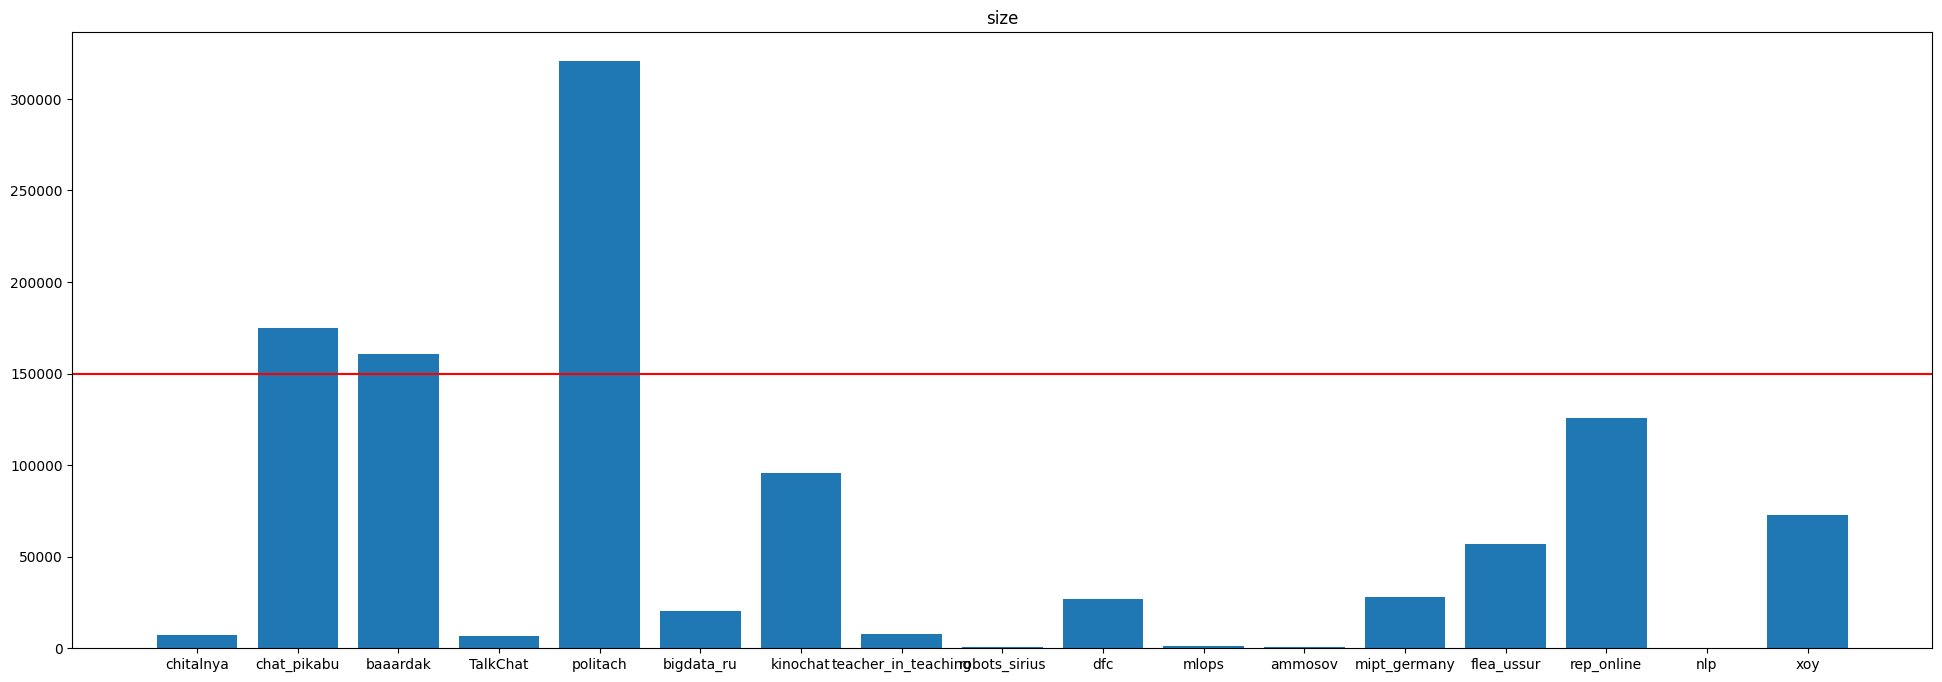

In [6]:
negative_ensemble = DatasetEnsemble([])
negative_ensemble.extend(*parse_tg_chats("message_classification/negative_tg_chats/russian_telegram_chats_history/",
                                        json_dict=True, target_features="text"))
negative_ensemble.extend(*parse_tg_chats("message_classification/negative_tg_chats/", 
                                         to_clone={"flea_ussur": 2, "xoy": 3, "dfc": 4, "mipt_germany": 4}))
negative_ensemble.datasets = [filter_short(x) for x in negative_ensemble.datasets]
negative_ensemble.clip(150000)

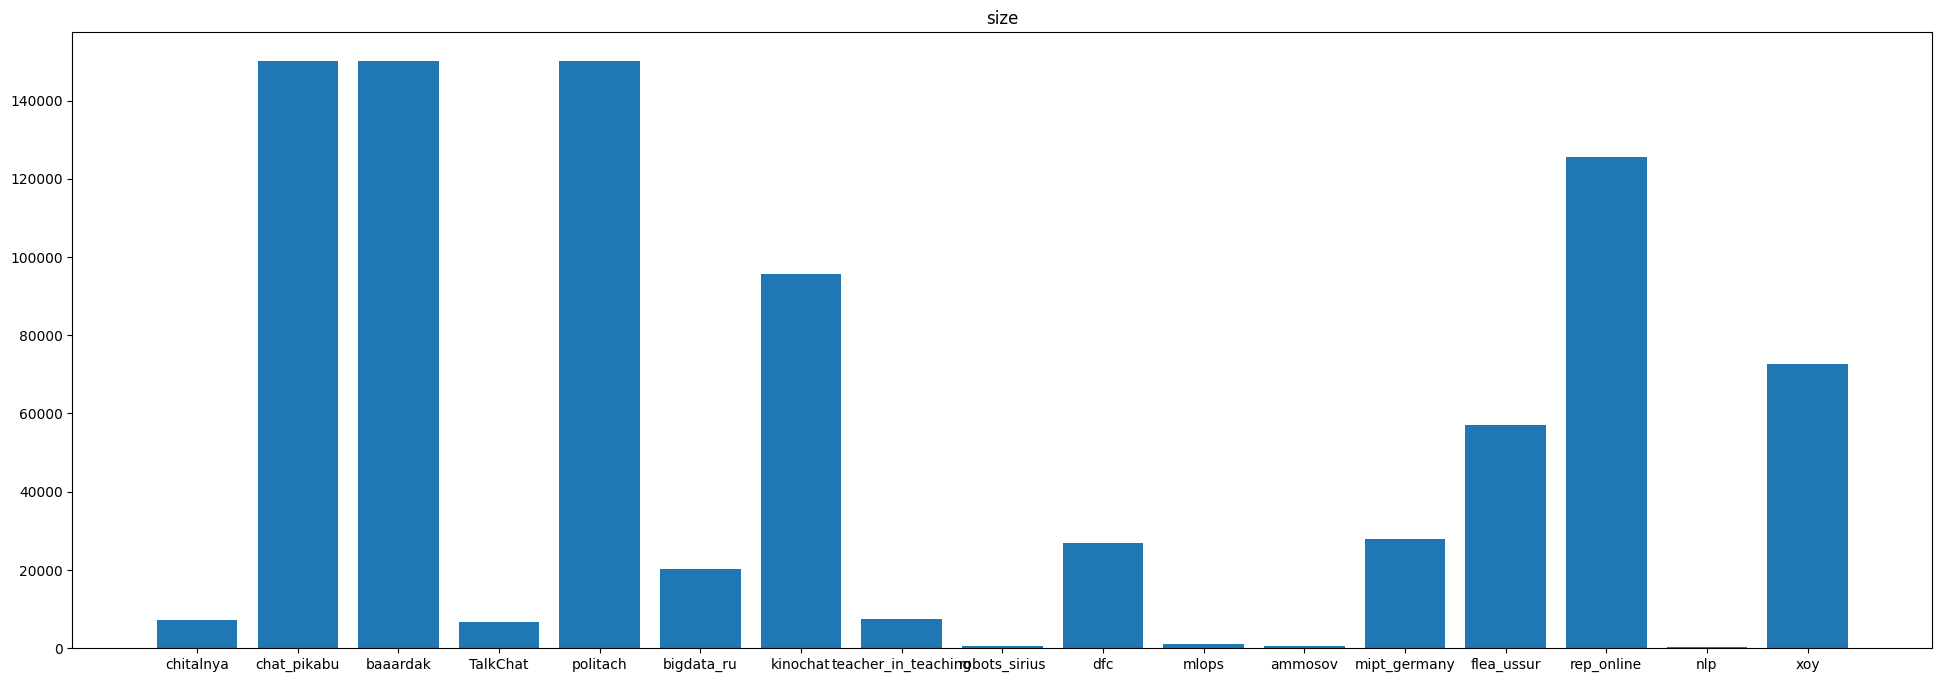

In [7]:
negative_ensemble.plot_lengths()

In [8]:
negative_dataset = negative_ensemble.merge()
negative_dataset = ApplyPreprocessors(negative_dataset, preprocessors=default_preprocessors)

### positive

In [9]:
positive_ensemble = DatasetEnsemble([])
positive_ensemble.extend(*parse_tg_chats("message_classification/positive_parsed_sites/", out_styled=True, sep="\",\n"))

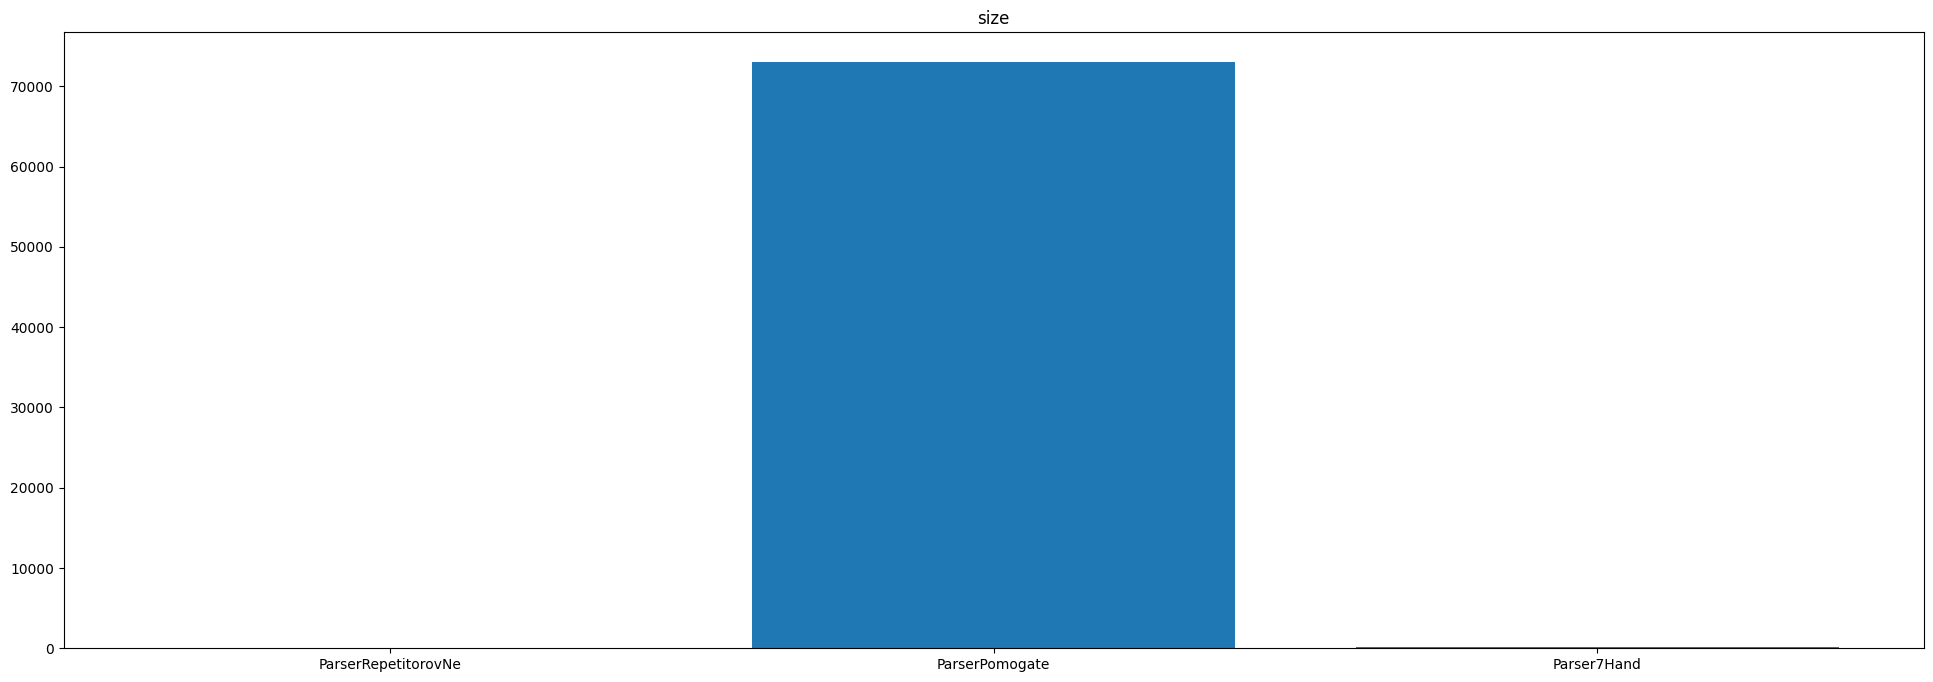

In [10]:
positive_ensemble.plot_lengths()

In [11]:
positive_dataset = positive_ensemble.merge()

def add_exclamation(array):
    return [" " + x for x in array + [x + "!" for x in array]]

def add_reversed(array):
    return array + [(x[1], x[0]) for x in array]

positive_dataset = spawn_clones(positive_dataset, len(negative_dataset) // len(positive_dataset))

positive_dataset = ApplyPreprocessors(positive_dataset, preprocessors=default_preprocessors + [
    AddPrefixWithProbability(prefixes=add_exclamation([
        "Привет", "здравствуйте", "добрый день", "доброе утро", "добрый вечер", "рад вас видеть", "приветствую", "доброго времени суток",
         "привет", "Здравствуйте", "Добрый день", "Доброе утро", "Добрый вечер", "Рад вас видеть", "Приветствую", "Доброго времени Суток",
    ]), prob=0.1),
    ReplaceWithProbability(replacements=add_reversed([
        (" учитель ", " преподаватель "),
        (" учитель ", " репетитор "),
        (" преподаватель ", " репетитор "),
        (" учителя ", " преподавателя "),
        (" учителя ", " репетитора "),
        (" преподавателя ", " репетитора "),
        (" учителем ", " преподавателем "),
        (" учителем ", " репетитором "),
        (" преподавателем ", " репетитором "),
    ]), prob=0.05)
])

## train
### tokenizing

In [12]:
import torch
from torch import nn
from nn.models.bert import HuggingFaceBertForClassification
from transformers import BertModel

from nn.models.tokenizers import HuggingFaceBertTokenizer
from nn.data.datasets import ApplyTokenizer
from nn.configs.train_configs import TrainConfig
from nn.train.trainers import DefaultTrainer
from nn.train.train import train
from nn.data.datasets import MergedDataset, ListDataset, merge_datasets

In [13]:
tokenizer = HuggingFaceBertTokenizer()
tokenizer.from_pretrained("cointegrated/rubert-tiny2")

print(len(positive_dataset), len(negative_dataset))

879036 899699


In [14]:
negative_dataset = MergedDataset([ApplyTokenizer(negative_dataset, tokenizer, log_interval=10000), ListDataset([0] * len(negative_dataset))])
positive_dataset = MergedDataset([ApplyTokenizer(positive_dataset, tokenizer, log_interval=10000), ListDataset([1] * len(positive_dataset))])
dataset = merge_datasets([positive_dataset, negative_dataset])

0
10000
20000
30000
40000
50000
60000
70000
80000
90000
100000
110000
120000
130000
140000
150000
160000


KeyboardInterrupt: 

### training

In [ ]:
model = HuggingFaceBertForClassification(BertModel.from_pretrained("cointegrated/rubert-tiny2"), num_labels=2)

In [ ]:
config = TrainConfig(
    epochs=1,
    batch_size=256,
    batches_accumulated=1,
    valid_share=0.1,
    device=torch.device("cuda:0"),
    text_logs=True,
    log_interval=5,
)

In [17]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4, weight_decay=0.1)
trainer = DefaultTrainer(
    optimizer=optimizer,
    loss_fn=nn.CrossEntropyLoss(),
    config=config
)

In [18]:
train(
    model=model,
    dataset=dataset,
    config=config,
    trainer=trainer
)

RuntimeError: stack expects each tensor to be equal size, but got [43] at entry 0 and [8] at entry 1